In [1]:
import pandas as pd
import numpy as np

import math
import torch
import gpytorch
from matplotlib import pyplot as plt

In [2]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error

In [3]:
df_clean = pd.read_csv("./yield_curve_2010_2018.csv",index_col=0).drop(columns="Date.1")
df_clean.index = pd.DatetimeIndex(df_clean.index)
df_clean = df_clean.sort_index()
print (df_clean.shape)
df_clean.head()

(2002, 11)


,1 Mo,3 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr
Date,,,,,,,,,,,
2010-01-04,0.05,0.08,0.18,0.45,1.09,1.66,2.65,3.36,3.85,4.60,4.65
2010-01-05,0.03,0.07,0.17,0.41,1.01,1.57,2.56,3.28,3.77,4.54,4.59
2010-01-06,0.03,0.06,0.15,0.40,1.01,1.60,2.60,3.33,3.85,4.63,4.70
2010-01-07,0.02,0.05,0.16,0.40,1.03,1.62,2.62,3.33,3.85,4.62,4.69
2010-01-08,0.02,0.05,0.15,0.37,0.96,1.56,2.57,3.31,3.83,4.61,4.70


# EDA
1. Hurst Component / Autocorelation
2. Persistence Model $\hat{Y}_{t+1} = Y_{t}$

In [4]:
def get_hurst_exponent(time_series, max_lag=20):
    """Returns the Hurst Exponent of the time series"""
    lags = range(2, max_lag)
    # variances of the lagged differences
    tau = [np.std(np.subtract(time_series[lag:], time_series[:-lag])) for lag in lags]
    # calculate the slope of the log plot -> the Hurst Exponent
    reg = np.polyfit(np.log(lags), np.log(tau), 1)
    return reg[0]

In [5]:
pd.DataFrame(df_clean.apply(lambda x: get_hurst_exponent(x.values, 40))).T

,1 Mo,3 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr
0,0.33008,0.460147,0.524739,0.498605,0.443841,0.469158,0.489996,0.490909,0.493751,0.489162,0.470324


### Train/Validation/Test
Train + Validation = 2010 to 2016  
Test = 2017

In [6]:
corr = df_clean.corr()
corr.style.background_gradient()

,1 Mo,3 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr
1 Mo,1.000000,0.992347,0.978688,0.955501,0.843656,0.658935,0.337214,0.125799,-0.076583,-0.235160,-0.277069
3 Mo,0.992347,1.000000,0.989907,0.968589,0.857941,0.671222,0.344163,0.129381,-0.077992,-0.239536,-0.281459
6 Mo,0.978688,0.989907,1.000000,0.989115,0.889561,0.700382,0.353527,0.124277,-0.103065,-0.277396,-0.318028
1 Yr,0.955501,0.968589,0.989115,1.000000,0.933835,0.762874,0.418554,0.181262,-0.066014,-0.258921,-0.302840
2 Yr,0.843656,0.857941,0.889561,0.933835,1.000000,0.938132,0.681302,0.456014,0.180907,-0.057811,-0.114843
3 Yr,0.658935,0.671222,0.700382,0.762874,0.938132,1.000000,0.880052,0.702053,0.439560,0.184803,0.119278
5 Yr,0.337214,0.344163,0.353527,0.418554,0.681302,0.880052,1.000000,0.952005,0.794160,0.591062,0.531850
7 Yr,0.125799,0.129381,0.124277,0.181262,0.456014,0.702053,0.952005,1.000000,0.939376,0.803195,0.757528
10 Yr,-0.076583,-0.077992,-0.103065,-0.066014,0.180907,0.439560,0.794160,0.939376,1.000000,0.957449,0.932447
20 Yr,-0.235160,-0.239536,-0.277396,-0.258921,-0.057811,0.184803,0.591062,0.803195,0.957449,1.000000,0.995390


In [7]:
# [["1 Mo","3 Mo","2 Yr", "10 Yr"]]
# [["1 Mo","3 Mo", "6 Mo","1 Yr" , "2 Yr", "2 Yr", "5 Yr" ,"10 Yr", "20 Yr" ,"30 Yr"]]

train_validation = df_clean.loc[:"2016"]
test = df_clean.loc["2017":]

Y_COLS = ["2 Yr", "10 Yr"]

train_validation.shape,test.shape

((1752, 11), (250, 11))

### Persistence Model

In [8]:
result_persist = pd.DataFrame()
tscv = TimeSeriesSplit(n_splits=4,test_size=250)
for i, (train_index, test_index) in enumerate(tscv.split(train_validation)):
    results_i = {}
    print(f"Fold {i}:")
    df_train_i = train_validation.iloc[train_index]
    df_test_i = train_validation.iloc[test_index]
    print(f"Training from {df_train_i.index.min()} to {df_train_i.index.max()}")
    print(f"Testing from {df_test_i.index.min()} to {df_test_i.index.max()}\n")
    #persistence model with rolling one day prediction
    # y_pred_i = pd.DataFrame([df_train_i.iloc[-1].values]*len(df_test_i),index=df_test_i.index,\
    #            columns = df_test_i.columns)
    y_pred_i = df_test_i[Y_COLS].shift(1).copy()
    y_pred_i.iloc[0] = df_train_i[Y_COLS].iloc[-1]
    results_i = {
      "fold":i,
      "test_year":df_test_i.index.year.max()}
    for test_col in Y_COLS:
        results_i[test_col] = {
          "RMSE": mean_squared_error(df_test_i[test_col],y_pred_i[test_col])**0.5,\
          "MAPE": mean_absolute_percentage_error(df_test_i[test_col],y_pred_i[test_col])    
        }
    result_persist = pd.concat([result_persist,pd.DataFrame.from_dict(results_i,orient="columns")])

Fold 0:
Training from 2010-01-04 00:00:00 to 2013-01-02 00:00:00
Testing from 2013-01-03 00:00:00 to 2014-01-02 00:00:00

Fold 1:
Training from 2010-01-04 00:00:00 to 2014-01-02 00:00:00
Testing from 2014-01-03 00:00:00 to 2015-01-02 00:00:00

Fold 2:
Training from 2010-01-04 00:00:00 to 2015-01-02 00:00:00
Testing from 2015-01-05 00:00:00 to 2015-12-31 00:00:00

Fold 3:
Training from 2010-01-04 00:00:00 to 2015-12-31 00:00:00
Testing from 2016-01-04 00:00:00 to 2016-12-30 00:00:00



In [9]:
result_persist.reset_index().drop(columns=["test_year"]).groupby("index").mean()

,fold,2 Yr,10 Yr
index,,,
MAPE,1.5,0.037410,0.016895
RMSE,1.5,0.027652,0.046315


# Use Gaussian Process to model yield curve
## Create lag variables for x

In [10]:
def create_lag_variables(df,y_cols,n_lags=2):
    df1= df.copy()
    col_list = df1.columns
    for lag_i in range(1,n_lags+1):
        df_lag_i = df1[col_list].shift(lag_i)
        df_lag_i.columns = [f"{col_i}_lag{lag_i}" for col_i in col_list]
        df1 = pd.merge(df1,df_lag_i,left_index=True,right_index=True)
    df1 = df1.dropna()
    X = df1.drop(columns=y_cols)
    y = df1[y_cols]
    return X,y

X,y = create_lag_variables(train_validation,Y_COLS,14)
X.shape,y.shape

((1738, 163), (1738, 2))

### Initialise GP model with variable kernel

In [11]:
class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, kernel_func, likelihood):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ConstantMean(), num_tasks=train_y.shape[-1]
        )
        self.covar_module = gpytorch.kernels.MultitaskKernel(
            kernel_func, num_tasks=train_y.shape[-1], rank=1
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)
    
def train_gp(train_x, train_y, kernel_func, N_ITER = 50,verbose=True):
    likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=train_y.shape[-1])
    if type(train_x) != torch.Tensor:
        train_x_tensor = torch.tensor(train_x.values).float()
        train_y_tensor = torch.tensor(train_y.values).float()
    else:
        train_x_tensor = train_x
        train_y_tensor = train_y
    model = MultitaskGPModel(train_x_tensor, train_y_tensor,kernel_func, likelihood)
#     print ("Initialised GP")
    # Find optimal model hyperparameters
    model.train()
    likelihood.train()
    # Use the adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters
    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
    print ("Training GP")
    for i in range(N_ITER):
        optimizer.zero_grad()
        output = model(train_x_tensor)
        loss = -mll(output, train_y_tensor)
        loss.backward()
        if verbose and ((i%10==0) or (i==N_ITER-1)):
            print('Iter %d/%d - Loss: %.3f' % (i + 1, N_ITER, loss.item()))
        optimizer.step()
    return model,likelihood

def predict_gp(test_x,likelihood,model):
    # Set into eval mode
    model.eval()
    likelihood.eval()
    test_x_tensor = torch.tensor(test_x.values).float()
    # Make predictions
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        predictions = likelihood(model(test_x_tensor))
        mean = predictions.mean
        # lower, upper = predictions.confidence_region()   
    return mean,predictions 

### Train with diff kernels

In [12]:
kernel_repo = {
    #SE
    "kernel1":gpytorch.kernels.RBFKernel(),\
    #SE*Lin
    "kernel2":gpytorch.kernels.RBFKernel()*gpytorch.kernels.LinearKernel(),\
    #Periodic*Lin
#     "kernel3":gpytorch.kernels.PeriodicKernel()*gpytorch.kernels.LinearKernel(),\
    #SE*Lin + RQ
#     "kernel4":gpytorch.kernels.RBFKernel()*gpytorch.kernels.LinearKernel() + gpytorch.kernels.RQKernel(),\
    #SE*Periodic + RQ
#     "kernel5":gpytorch.kernels.RBFKernel()*gpytorch.kernels.PeriodicKernel() + gpytorch.kernels.RQKernel()
}

In [13]:
def get_kernel_cv_result_raw(kernel_j, N_TRIALS=10, N_TRAINING_ITER=50, verbose=False):
    result_j = pd.DataFrame()
    model_dict_j = {}
    for trial in range(N_TRIALS):
        for i, (train_index, test_index) in enumerate(tscv.split(X)):
            print(f"Sample {trial}, Fold {i}:")
            train_xi,train_yi = X.iloc[train_index],y.iloc[train_index]
            test_xi,test_yi = X.iloc[test_index],y.iloc[test_index]
#             if verbose:
#                 print(f"Training from {train_xi.index.min()} to {train_xi.index.max()}")
            model_i,lik_i = train_gp(train_xi,train_yi,kernel_j,N_TRAINING_ITER,verbose)
            model_dict_j[trial,i,"model"]=model_i
            if verbose:
                print(f"Testing from {test_xi.index.min()} to {test_xi.index.max()}\n")
            mean_i,pred_i = predict_gp(test_xi,lik_i,model_i)
            model_dict_j[trial,i,"prediction"]=pred_i
            results_i = {
              "trial":trial,
              "fold":i,
              "test_year":test_xi.index.year.max()}
            y_pred_i = pd.DataFrame(mean_i,index=test_yi.index,columns = test_yi.columns)
            for test_col in test_yi.columns:
                results_i[test_col] = {
                  "RMSE": mean_squared_error(test_yi[test_col],y_pred_i[test_col])**0.5,\
                  "MAPE": mean_absolute_percentage_error(test_yi[test_col],y_pred_i[test_col])    
                }
            result_j = pd.concat([result_j,pd.DataFrame.from_dict(results_i,orient="columns")])
    return (result_j,model_dict_j)

In [14]:
result_test,model_test = get_kernel_cv_result_raw(gpytorch.kernels.RBFKernel(),3,10,True)
results_trials = result_test.loc["RMSE"].reset_index().drop(columns=["test_year","fold"]).groupby(["trial","index"]).mean()
results_trials["err_avg"] = results_trials.mean(axis=1)
results_trials["rnk_"] = results_trials["err_avg"].rank()
results_trials.loc[results_trials.rnk_==1]

Sample 0, Fold 0:
Training GP
Iter 1/10 - Loss: 1.481
Iter 10/10 - Loss: 0.920
Testing from 2013-01-03 00:00:00 to 2014-01-02 00:00:00

Sample 0, Fold 1:
Training GP
Iter 1/10 - Loss: 1.314
Iter 10/10 - Loss: 0.847
Testing from 2014-01-03 00:00:00 to 2015-01-02 00:00:00

Sample 0, Fold 2:
Training GP
Iter 1/10 - Loss: 1.155
Iter 10/10 - Loss: 0.776
Testing from 2015-01-05 00:00:00 to 2015-12-31 00:00:00

Sample 0, Fold 3:
Training GP
Iter 1/10 - Loss: 1.136
Iter 10/10 - Loss: 0.758
Testing from 2016-01-04 00:00:00 to 2016-12-30 00:00:00

Sample 1, Fold 0:
Training GP
Iter 1/10 - Loss: 1.128
Iter 10/10 - Loss: 0.760
Testing from 2013-01-03 00:00:00 to 2014-01-02 00:00:00

Sample 1, Fold 1:
Training GP
Iter 1/10 - Loss: 1.114
Iter 10/10 - Loss: 0.751
Testing from 2014-01-03 00:00:00 to 2015-01-02 00:00:00

Sample 1, Fold 2:
Training GP
Iter 1/10 - Loss: 1.108
Iter 10/10 - Loss: 0.749
Testing from 2015-01-05 00:00:00 to 2015-12-31 00:00:00

Sample 1, Fold 3:
Training GP
Iter 1/10 - Loss: 

,,2 Yr,10 Yr,err_avg,rnk_
trial,index,,,,
2,RMSE,0.091427,0.052574,0.072,1.0


In [15]:
torch.save(model_test[(0,0,'model')].state_dict(), "./sample_model_save.sav")

#### Iterate over kernel model

In [16]:
all_results = {}
all_results_df = pd.DataFrame()
for kernel_name,kernel_func_j in kernel_repo.items():
    print (f"Using {kernel_name}")
    kernel_result,kernel_models = get_kernel_cv_result_raw(kernel_func_j,10,200,True)
    kernel_results_trials = kernel_result.loc["RMSE"].reset_index().drop(columns=["fold","test_year"]).groupby(["trial","index"]).mean()
    kernel_results_trials["err_avg"] = kernel_results_trials.mean(axis=1)
    kernel_results_trials["rnk_"] = kernel_results_trials["err_avg"].rank()
    all_results[kernel_name] = (kernel_results_trials,kernel_models)
    result_i = kernel_results_trials.copy()
    result_i = result_i.loc[result_i.rnk_==1]
    result_i["kernel"] = kernel_name
    all_results_df = pd.concat([all_results_df,result_i])

Using kernel1
Sample 0, Fold 0:
Training GP
Iter 1/200 - Loss: 1.515
Iter 11/200 - Loss: 0.864
Iter 21/200 - Loss: 0.325
Iter 31/200 - Loss: -0.216
Iter 41/200 - Loss: -0.738
Iter 51/200 - Loss: -1.223
Iter 61/200 - Loss: -1.654
Iter 71/200 - Loss: -1.999
Iter 81/200 - Loss: -2.239
Iter 91/200 - Loss: -2.394
Iter 101/200 - Loss: -2.487
Iter 111/200 - Loss: -2.544
Iter 121/200 - Loss: -2.582
Iter 131/200 - Loss: -2.608
Iter 141/200 - Loss: -2.627
Iter 151/200 - Loss: -2.642
Iter 161/200 - Loss: -2.654
Iter 171/200 - Loss: -2.664
Iter 181/200 - Loss: -2.672
Iter 191/200 - Loss: -2.680
Iter 200/200 - Loss: -2.685
Testing from 2013-01-03 00:00:00 to 2014-01-02 00:00:00

Sample 0, Fold 1:
Training GP
Iter 1/200 - Loss: 1.102
Iter 11/200 - Loss: 0.702
Iter 21/200 - Loss: 0.242
Iter 31/200 - Loss: -0.250
Iter 41/200 - Loss: -0.748
Iter 51/200 - Loss: -1.233
Iter 61/200 - Loss: -1.685
Iter 71/200 - Loss: -2.077
Iter 81/200 - Loss: -2.378
Iter 91/200 - Loss: -2.573
Iter 101/200 - Loss: -2.682
I

Iter 91/200 - Loss: -2.544
Iter 101/200 - Loss: -2.647
Iter 111/200 - Loss: -2.701
Iter 121/200 - Loss: -2.730
Iter 131/200 - Loss: -2.747
Iter 141/200 - Loss: -2.758
Iter 151/200 - Loss: -2.766
Iter 161/200 - Loss: -2.772
Iter 171/200 - Loss: -2.777
Iter 181/200 - Loss: -2.780
Iter 191/200 - Loss: -2.783
Iter 200/200 - Loss: -2.786
Testing from 2013-01-03 00:00:00 to 2014-01-02 00:00:00

Sample 3, Fold 1:
Training GP
Iter 1/200 - Loss: 1.100
Iter 11/200 - Loss: 0.699
Iter 21/200 - Loss: 0.240
Iter 31/200 - Loss: -0.253
Iter 41/200 - Loss: -0.755
Iter 51/200 - Loss: -1.245
Iter 61/200 - Loss: -1.703
Iter 71/200 - Loss: -2.102
Iter 81/200 - Loss: -2.408
Iter 91/200 - Loss: -2.603
Iter 101/200 - Loss: -2.709
Iter 111/200 - Loss: -2.765
Iter 121/200 - Loss: -2.794
Iter 131/200 - Loss: -2.812
Iter 141/200 - Loss: -2.823
Iter 151/200 - Loss: -2.831
Iter 161/200 - Loss: -2.837
Iter 171/200 - Loss: -2.841
Iter 181/200 - Loss: -2.845
Iter 191/200 - Loss: -2.848
Iter 200/200 - Loss: -2.850
Test

Iter 191/200 - Loss: -2.783
Iter 200/200 - Loss: -2.786
Testing from 2013-01-03 00:00:00 to 2014-01-02 00:00:00

Sample 6, Fold 1:
Training GP
Iter 1/200 - Loss: 1.107
Iter 11/200 - Loss: 0.700
Iter 21/200 - Loss: 0.241
Iter 31/200 - Loss: -0.253
Iter 41/200 - Loss: -0.755
Iter 51/200 - Loss: -1.245
Iter 61/200 - Loss: -1.702
Iter 71/200 - Loss: -2.100
Iter 81/200 - Loss: -2.406
Iter 91/200 - Loss: -2.602
Iter 101/200 - Loss: -2.708
Iter 111/200 - Loss: -2.763
Iter 121/200 - Loss: -2.793
Iter 131/200 - Loss: -2.811
Iter 141/200 - Loss: -2.822
Iter 151/200 - Loss: -2.830
Iter 161/200 - Loss: -2.836
Iter 171/200 - Loss: -2.840
Iter 181/200 - Loss: -2.844
Iter 191/200 - Loss: -2.847
Iter 200/200 - Loss: -2.849
Testing from 2014-01-03 00:00:00 to 2015-01-02 00:00:00

Sample 6, Fold 2:
Training GP
Iter 1/200 - Loss: 1.113
Iter 11/200 - Loss: 0.699
Iter 21/200 - Loss: 0.239
Iter 31/200 - Loss: -0.256
Iter 41/200 - Loss: -0.760
Iter 51/200 - Loss: -1.254
Iter 61/200 - Loss: -1.719
Iter 71/200

Iter 51/200 - Loss: -1.244
Iter 61/200 - Loss: -1.702
Iter 71/200 - Loss: -2.100
Iter 81/200 - Loss: -2.406
Iter 91/200 - Loss: -2.602
Iter 101/200 - Loss: -2.708
Iter 111/200 - Loss: -2.763
Iter 121/200 - Loss: -2.793
Iter 131/200 - Loss: -2.811
Iter 141/200 - Loss: -2.822
Iter 151/200 - Loss: -2.830
Iter 161/200 - Loss: -2.836
Iter 171/200 - Loss: -2.841
Iter 181/200 - Loss: -2.844
Iter 191/200 - Loss: -2.847
Iter 200/200 - Loss: -2.850
Testing from 2014-01-03 00:00:00 to 2015-01-02 00:00:00

Sample 9, Fold 2:
Training GP
Iter 1/200 - Loss: 1.098
Iter 11/200 - Loss: 0.697
Iter 21/200 - Loss: 0.238
Iter 31/200 - Loss: -0.256
Iter 41/200 - Loss: -0.760
Iter 51/200 - Loss: -1.254
Iter 61/200 - Loss: -1.719
Iter 71/200 - Loss: -2.126
Iter 81/200 - Loss: -2.440
Iter 91/200 - Loss: -2.640
Iter 101/200 - Loss: -2.749
Iter 111/200 - Loss: -2.806
Iter 121/200 - Loss: -2.836
Iter 131/200 - Loss: -2.854
Iter 141/200 - Loss: -2.865
Iter 151/200 - Loss: -2.873
Iter 161/200 - Loss: -2.879
Iter 171

Iter 141/200 - Loss: -2.836
Iter 151/200 - Loss: -2.843
Iter 161/200 - Loss: -2.849
Iter 171/200 - Loss: -2.852
Iter 181/200 - Loss: -2.856
Iter 191/200 - Loss: -2.859
Iter 200/200 - Loss: -2.860
Testing from 2014-01-03 00:00:00 to 2015-01-02 00:00:00

Sample 2, Fold 2:
Training GP
Iter 1/200 - Loss: 1.135
Iter 11/200 - Loss: 0.722
Iter 21/200 - Loss: 0.251
Iter 31/200 - Loss: -0.257
Iter 41/200 - Loss: -0.768
Iter 51/200 - Loss: -1.268
Iter 61/200 - Loss: -1.736
Iter 71/200 - Loss: -2.147
Iter 81/200 - Loss: -2.460
Iter 91/200 - Loss: -2.658
Iter 101/200 - Loss: -2.764
Iter 111/200 - Loss: -2.818
Iter 121/200 - Loss: -2.848
Iter 131/200 - Loss: -2.863
Iter 141/200 - Loss: -2.872
Iter 151/200 - Loss: -2.878
Iter 161/200 - Loss: -2.888
Iter 171/200 - Loss: -2.893
Iter 181/200 - Loss: -2.897
Iter 191/200 - Loss: -2.899
Iter 200/200 - Loss: -2.902
Testing from 2015-01-05 00:00:00 to 2015-12-31 00:00:00

Sample 2, Fold 3:
Training GP
Iter 1/200 - Loss: 1.177
Iter 11/200 - Loss: 0.753
Iter 

Iter 1/200 - Loss: 1.165
Iter 11/200 - Loss: 0.756
Iter 21/200 - Loss: 0.284
Iter 31/200 - Loss: -0.229
Iter 41/200 - Loss: -0.758
Iter 51/200 - Loss: -1.272
Iter 61/200 - Loss: -1.748
Iter 71/200 - Loss: -2.160
Iter 81/200 - Loss: -2.474
Iter 91/200 - Loss: -2.668
Iter 101/200 - Loss: -2.772
Iter 111/200 - Loss: -2.823
Iter 121/200 - Loss: -2.851
Iter 131/200 - Loss: -2.868
Iter 141/200 - Loss: -2.878
Iter 151/200 - Loss: -2.885
Iter 161/200 - Loss: -2.890
Iter 171/200 - Loss: -2.896
Iter 181/200 - Loss: -2.899
Iter 191/200 - Loss: -2.903
Iter 200/200 - Loss: -2.904
Testing from 2015-01-05 00:00:00 to 2015-12-31 00:00:00

Sample 5, Fold 3:
Training GP
Iter 1/200 - Loss: 1.145
Iter 11/200 - Loss: 0.729
Iter 21/200 - Loss: 0.259
Iter 31/200 - Loss: -0.249
Iter 41/200 - Loss: -0.769
Iter 51/200 - Loss: -1.275
Iter 61/200 - Loss: -1.748
Iter 71/200 - Loss: -2.163
Iter 81/200 - Loss: -2.478
Iter 91/200 - Loss: -2.677
Iter 101/200 - Loss: -2.782
Iter 111/200 - Loss: -2.836
Iter 121/200 - Lo

Iter 101/200 - Loss: -2.776
Iter 111/200 - Loss: -2.827
Iter 121/200 - Loss: -2.854
Iter 131/200 - Loss: -2.870
Iter 141/200 - Loss: -2.855
Iter 151/200 - Loss: -2.887
Iter 161/200 - Loss: -2.893
Iter 171/200 - Loss: -2.897
Iter 181/200 - Loss: -2.901
Iter 191/200 - Loss: -2.904
Iter 200/200 - Loss: -2.905
Testing from 2015-01-05 00:00:00 to 2015-12-31 00:00:00

Sample 8, Fold 3:
Training GP
Iter 1/200 - Loss: 1.163
Iter 11/200 - Loss: 0.738
Iter 21/200 - Loss: 0.269
Iter 31/200 - Loss: -0.244
Iter 41/200 - Loss: -0.765
Iter 51/200 - Loss: -1.276
Iter 61/200 - Loss: -1.753
Iter 71/200 - Loss: -2.168
Iter 81/200 - Loss: -2.484
Iter 91/200 - Loss: -2.681
Iter 101/200 - Loss: -2.785
Iter 111/200 - Loss: -2.838
Iter 121/200 - Loss: -2.866
Iter 131/200 - Loss: -2.879
Iter 141/200 - Loss: -2.883
Iter 151/200 - Loss: -2.900
Iter 161/200 - Loss: -2.907
Iter 171/200 - Loss: -2.910
Iter 181/200 - Loss: -2.914
Iter 191/200 - Loss: -2.916
Iter 200/200 - Loss: -2.919
Testing from 2016-01-04 00:00:0

In [17]:
all_results_df

,,2 Yr,10 Yr,err_avg,rnk_,kernel
trial,index,,,,,
5,RMSE,0.016825,0.010137,0.013481,1.0,kernel1
7,RMSE,0.014184,0.008974,0.011579,1.0,kernel2


In [18]:
all_results_df.to_csv("all_results_validation_df.csv")

### Plot prediction of kernel1/kernel2 on 2016

In [28]:
#Gdata
data_2016 = train_validation.loc["2016"]
X_test_2016,y_test_2016 = create_lag_variables(data_2016,Y_COLS,14) #lagged data for predicting

#Persistence model
perists_pred_2016 = y_test_2016[Y_COLS].shift(1).copy()
perists_pred_2016.iloc[0] = train_validation.loc[:"2015"][Y_COLS].iloc[-1]

# likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=train_y.shape[-1])
model1 = all_results["kernel1"][1][(5, 2, 'model')]
lik1 = model1.likelihood
pred_kernel1,pred1 = predict_gp(X_test_2016,lik1,model1)
pred_kernel1 = pd.DataFrame(pred_kernel1,index=y_test_2016.index,columns = y_test_2016.columns)

# likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=train_y.shape[-1])
model2 = all_results["kernel2"][1][(7, 2, 'model')]
lik2 = model2.likelihood
pred_kernel2,pred2 = predict_gp(X_test_2016,lik2,model2)
pred_kernel2 = pd.DataFrame(pred_kernel2,index=y_test_2016.index,columns = y_test_2016.columns)

In [29]:
join1 = pd.merge(y_test_2016,perists_pred_2016,suffixes=["","_persist"],left_index=True,right_index=True)
join2 = pd.merge(join1,pred_kernel1,suffixes=["","_kernel1"],left_index=True,right_index=True)
joinf_2016 = pd.merge(join2,pred_kernel2,suffixes=["_org","_kernel2"],left_index=True,right_index=True)

joinf_2016[["2 Yr_kernel1_stddev","10 Yr_kernel1_stddev"]] = pred1.variance.detach().numpy()**0.5
joinf_2016[["2 Yr_kernel2_stddev","10 Yr_kernel2_stddev"]] = pred2.variance.detach().numpy()**0.5

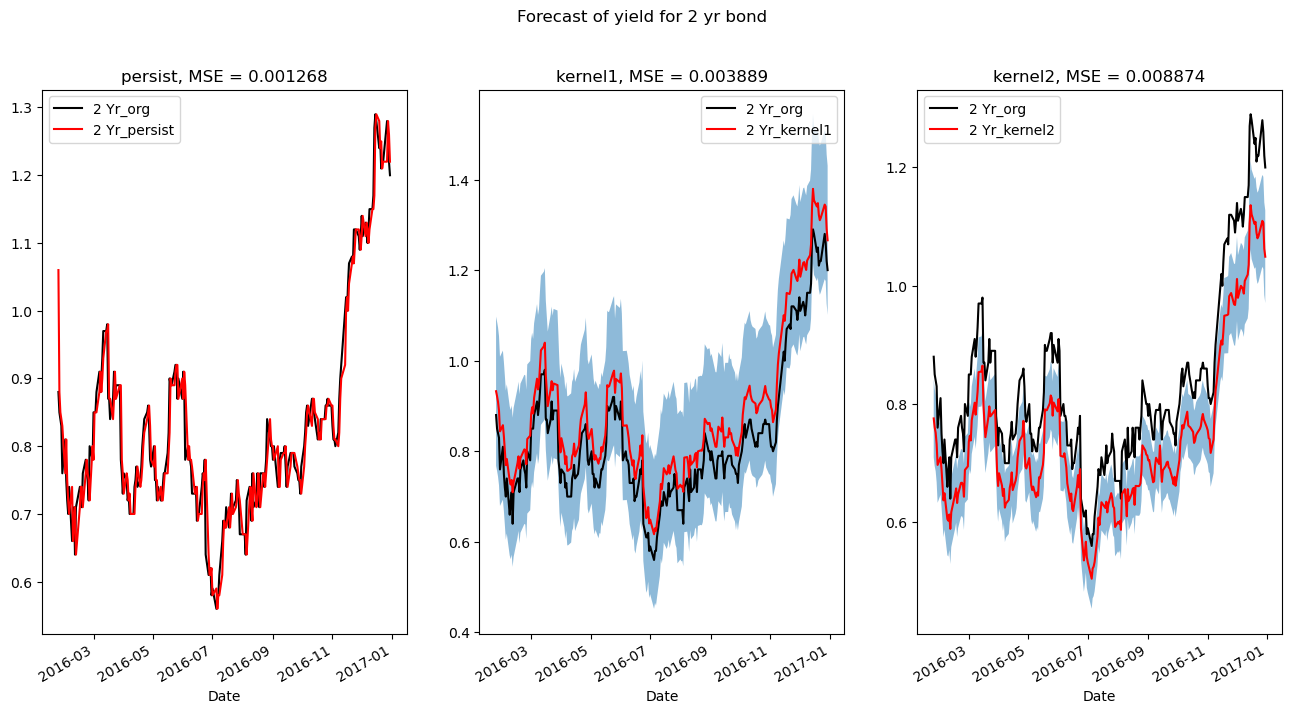

In [30]:
fig,ax = plt.subplots(1,3,figsize=(16,8))
fig.suptitle("Forecast of yield for 2 yr bond")
for i,model_type_i in enumerate(["persist","kernel1","kernel2"]):
    ax_i = ax[i]
    y_i = joinf_2016[f"2 Yr_{model_type_i}"]
    mse_i = mean_squared_error(joinf_2016["2 Yr_org"],y_i)
    joinf_2016[["2 Yr_org",f"2 Yr_{model_type_i}"]].plot(ax=ax_i,color=("k","r"))
    ax_i.set_title(f"{model_type_i}, MSE = {mse_i:.6f}")
    if model_type_i != "persist":
        ax_i.fill_between(joinf_2016.index, y_i - 0.05*joinf_2016[f"2 Yr_{model_type_i}_stddev"],\
                          y_i + 0.05*joinf_2016[f"2 Yr_{model_type_i}_stddev"], alpha=0.5)

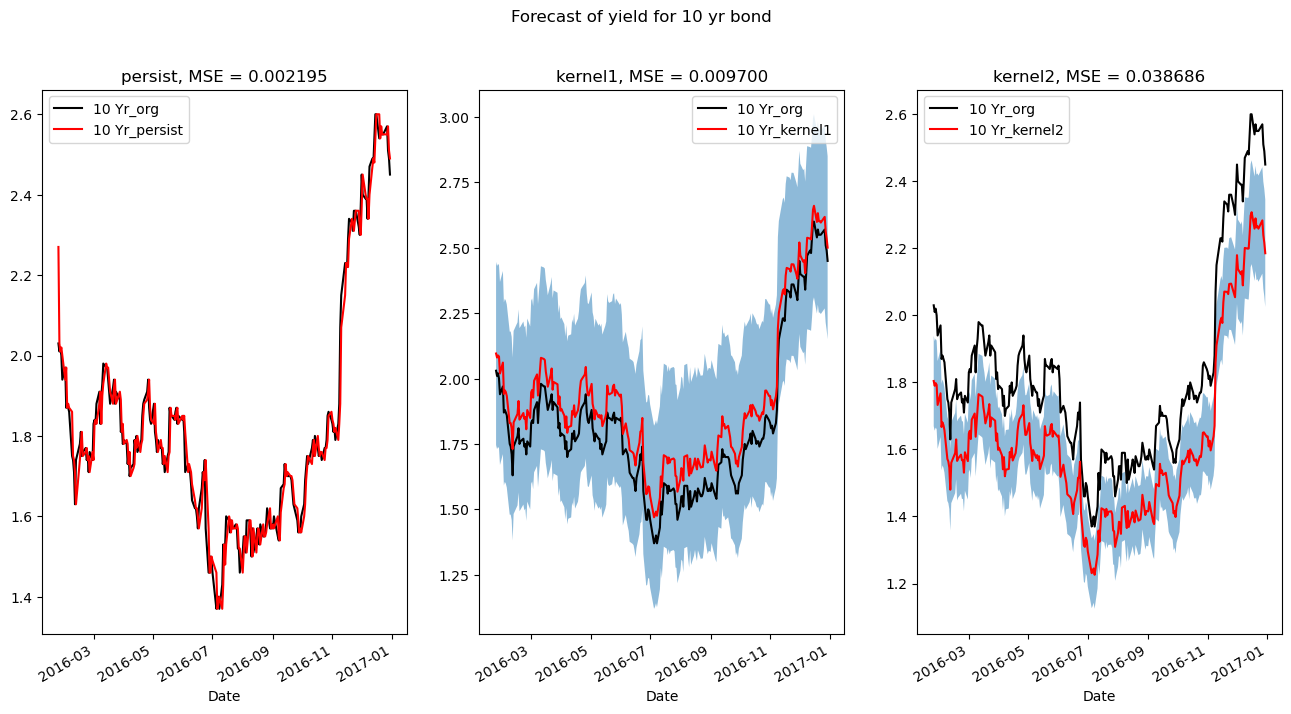

In [31]:
fig,ax = plt.subplots(1,3,figsize=(16,8))
fig.suptitle("Forecast of yield for 10 yr bond")
for i,model_type_i in enumerate(["persist","kernel1","kernel2"]):
    ax_i = ax[i]
    y_i = joinf_2016[f"10 Yr_{model_type_i}"]
    mse_i = mean_squared_error(joinf_2016["10 Yr_org"],y_i)
    joinf_2016[["10 Yr_org",f"10 Yr_{model_type_i}"]].plot(ax=ax_i,color=("k","r"))
    ax_i.set_title(f"{model_type_i}, MSE = {mse_i:.6f}")
    if model_type_i != "persist":
        ax_i.fill_between(joinf_2016.index, y_i - 0.1*joinf_2016[f"10 Yr_{model_type_i}_stddev"],\
                          y_i + 0.1*joinf_2016[f"10 Yr_{model_type_i}_stddev"], alpha=0.5)

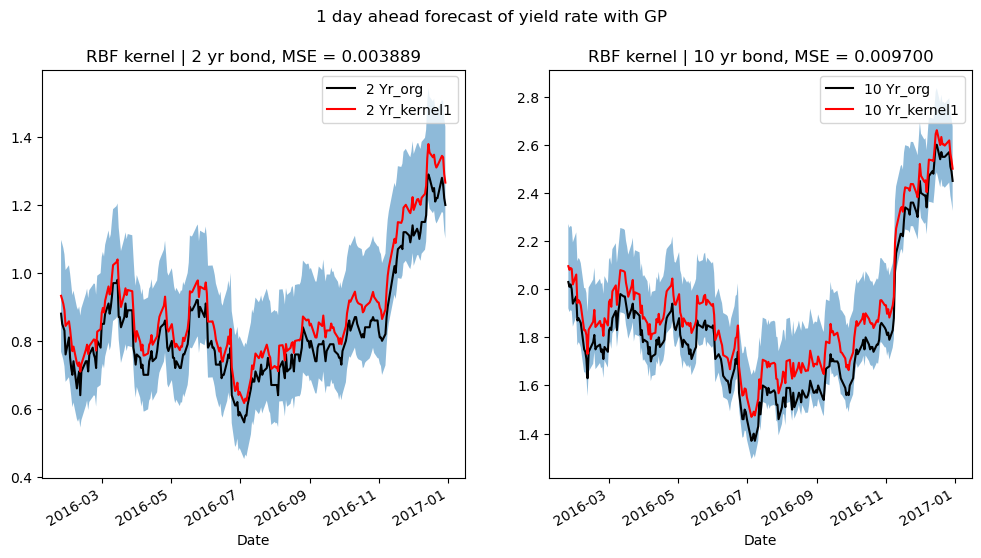

In [32]:
fig,ax = plt.subplots(1,2,figsize=(12,6))
fig.suptitle("1 day ahead forecast of yield rate with GP")
model_type_i="kernel1"
for i,bond_i in enumerate([2,10]):
    ax_i = ax[i]
    y_i = joinf_2016[f"{bond_i} Yr_{model_type_i}"]
    mse_i = mean_squared_error(joinf_2016[f"{bond_i} Yr_org"],y_i)
    joinf_2016[[f"{bond_i} Yr_org",f"{bond_i} Yr_{model_type_i}"]].plot(ax=ax_i,color=("k","r"))
    ax_i.set_title(f"RBF kernel | {bond_i} yr bond, MSE = {mse_i:.6f}")
    if model_type_i != "persist":
        ax_i.fill_between(joinf_2016.index, y_i - 0.05*joinf_2016[f"{bond_i} Yr_{model_type_i}_stddev"],\
                          y_i + 0.05*joinf_2016[f"{bond_i} Yr_{model_type_i}_stddev"], alpha=0.5)

# Train the best model on full data
- kernel2

In [ ]:
def get_kernel_result_final(kernel_j, N_TRIALS=10, N_TRAINING_ITER=50, verbose=False):
    result_j = pd.DataFrame()
    model_dict_j = {}
    for trial in range(N_TRIALS):
        print(f"Sample {trial}, Fold {i}:")
        train_xi,train_yi = X,y
        model_i,lik_i = train_gp(train_xi,train_yi,kernel_j,N_TRAINING_ITER,verbose)
        model_dict_j[trial,i,"model"]=model_i
            mean_i,pred_i = predict_gp(test_xi,lik_i,model_i)
            model_dict_j[trial,i,"prediction"]=pred_i
            results_i = {
              "trial":trial,
              "fold":i,
              "test_year":test_xi.index.year.max()}
            y_pred_i = pd.DataFrame(mean_i,index=test_yi.index,columns = test_yi.columns)
            for test_col in test_yi.columns:
                results_i[test_col] = {
                  "RMSE": mean_squared_error(test_yi[test_col],y_pred_i[test_col])**0.5,\
                  "MAPE": mean_absolute_percentage_error(test_yi[test_col],y_pred_i[test_col])    
                }
            result_j = pd.concat([result_j,pd.DataFrame.from_dict(results_i,orient="columns")])
    return (result_j,model_dict_j)

In [39]:
kernel_func_f = kernel_repo["kernel2"]
loss_final = {}
model_dict_final = {}
for trial in range(25):
    print(f"Sample {trial}")
    train_xi,train_yi = X,y
    model_i,lik_i = train_gp(train_xi,train_yi,kernel_func_f,250,1)
    mll_i = gpytorch.mlls.ExactMarginalLogLikelihood(lik_i, model_i)
    loss_final[trial] = mll_i
    model_dict_final[trial,"model"]=model_i

Sample 0
Training GP
Iter 1/250 - Loss: 1.179
Iter 11/250 - Loss: 0.762
Iter 21/250 - Loss: 0.276
Iter 31/250 - Loss: -0.236
Iter 41/250 - Loss: -0.759
Iter 51/250 - Loss: -1.280
Iter 61/250 - Loss: -1.764
Iter 71/250 - Loss: -2.183
Iter 81/250 - Loss: -2.501
Iter 91/250 - Loss: -2.698
Iter 101/250 - Loss: -2.801
Iter 111/250 - Loss: -2.853
Iter 121/250 - Loss: -2.869
Iter 131/250 - Loss: -2.895
Iter 141/250 - Loss: -2.908
Iter 151/250 - Loss: -2.915
Iter 161/250 - Loss: -2.920
Iter 171/250 - Loss: -2.924
Iter 181/250 - Loss: -2.929
Iter 191/250 - Loss: -2.932
Iter 201/250 - Loss: -2.933
Iter 211/250 - Loss: -2.936
Iter 221/250 - Loss: -2.937
Iter 231/250 - Loss: -2.938
Iter 241/250 - Loss: -2.939
Iter 250/250 - Loss: -2.941
Sample 1
Training GP
Iter 1/250 - Loss: 1.172
Iter 11/250 - Loss: 0.754
Iter 21/250 - Loss: 0.287
Iter 31/250 - Loss: -0.221
Iter 41/250 - Loss: -0.743
Iter 51/250 - Loss: -1.261
Iter 61/250 - Loss: -1.752
Iter 71/250 - Loss: -2.177
Iter 81/250 - Loss: -2.496
Iter 

Iter 41/250 - Loss: -0.681
Iter 51/250 - Loss: -1.205
Iter 61/250 - Loss: -1.709
Iter 71/250 - Loss: -2.158
Iter 81/250 - Loss: -2.501
Iter 91/250 - Loss: -2.700
Iter 101/250 - Loss: -2.803
Iter 111/250 - Loss: -2.856
Iter 121/250 - Loss: -2.884
Iter 131/250 - Loss: -2.901
Iter 141/250 - Loss: -2.910
Iter 151/250 - Loss: -2.917
Iter 161/250 - Loss: -2.923
Iter 171/250 - Loss: -2.927
Iter 181/250 - Loss: -2.930
Iter 191/250 - Loss: -2.932
Iter 201/250 - Loss: -2.934
Iter 211/250 - Loss: -2.936
Iter 221/250 - Loss: -2.938
Iter 231/250 - Loss: -2.939
Iter 241/250 - Loss: -2.929
Iter 250/250 - Loss: -2.917
Sample 12
Training GP
Iter 1/250 - Loss: 1.204
Iter 11/250 - Loss: 0.793
Iter 21/250 - Loss: 0.325
Iter 31/250 - Loss: -0.182
Iter 41/250 - Loss: -0.705
Iter 51/250 - Loss: -1.228
Iter 61/250 - Loss: -1.727
Iter 71/250 - Loss: -2.166
Iter 81/250 - Loss: -2.492
Iter 91/250 - Loss: -2.701
Iter 101/250 - Loss: -2.804
Iter 111/250 - Loss: -2.831
Iter 121/250 - Loss: -2.883
Iter 131/250 - Los

Iter 81/250 - Loss: -2.513
Iter 91/250 - Loss: -2.702
Iter 101/250 - Loss: -2.802
Iter 111/250 - Loss: -2.831
Iter 121/250 - Loss: -2.873
Iter 131/250 - Loss: -2.898
Iter 141/250 - Loss: -2.910
Iter 151/250 - Loss: -2.918
Iter 161/250 - Loss: -2.922
Iter 171/250 - Loss: -2.927
Iter 181/250 - Loss: -2.930
Iter 191/250 - Loss: -2.932
Iter 201/250 - Loss: -2.935
Iter 211/250 - Loss: -2.937
Iter 221/250 - Loss: -2.938
Iter 231/250 - Loss: -2.940
Iter 241/250 - Loss: -2.941
Iter 250/250 - Loss: -2.942
Sample 23
Training GP
Iter 1/250 - Loss: 1.242
Iter 11/250 - Loss: 0.819
Iter 21/250 - Loss: 0.362
Iter 31/250 - Loss: -0.147
Iter 41/250 - Loss: -0.673
Iter 51/250 - Loss: -1.199
Iter 61/250 - Loss: -1.705
Iter 71/250 - Loss: -2.156
Iter 81/250 - Loss: -2.500
Iter 91/250 - Loss: -2.707
Iter 101/250 - Loss: -2.809
Iter 111/250 - Loss: -2.858
Iter 121/250 - Loss: -2.874
Iter 131/250 - Loss: -2.900
Iter 141/250 - Loss: -2.908
Iter 151/250 - Loss: -2.917
Iter 161/250 - Loss: -2.922
Iter 171/250 -

In [54]:
train_x_tensor = torch.tensor(X.values).float()
train_y_tensor = torch.tensor(y.values).float()

loss_final = {}

for trial,model_i in model_dict_final.items():
    trial = trial[0]
    print (trial)
    lik_i = model_i.likelihood
    mll_i = gpytorch.mlls.ExactMarginalLogLikelihood(lik_i, model_i)
    output = model_i(train_x_tensor)
    loss = -mll_i(output, train_y_tensor)
    loss_final[trial] = loss.item()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


In [75]:
best_trial = min(loss_final, key=loss_final.get)
best_model = model_dict_final[trial,"model"]

torch.save(best_model, "./best_model.sav")

#### Test the best model on final test

In [76]:
#lagged data for predicting
X_test_2017,y_test_2017 = create_lag_variables(test,Y_COLS,14)

#Persistence model
perists_pred_2017 = y_test_2017[Y_COLS].shift(1).copy()
perists_pred_2017.iloc[0] = train_validation[Y_COLS].iloc[-1]

# likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=train_y.shape[-1])
best_lik = best_model.likelihood
pred_kernel_best,pred_best = predict_gp(X_test_2017,lik1,model1)
pred_kernel_best = pd.DataFrame(pred_kernel_best,index=y_test_2017.index,columns = y_test_2017.columns)

#join preds
join1 = pd.merge(y_test_2017,perists_pred_2017,suffixes=["","_persist"],left_index=True,right_index=True)
joinf_2017 = pd.merge(join1,pred_kernel_best,suffixes=["_org","_kernel2"],left_index=True,right_index=True)

joinf_2017[["2 Yr_kernel2_stddev","10 Yr_kernel2_stddev"]] = pred_best.variance.detach().numpy()**0.5

In [80]:
for yr in [2,10]:
    for i,model_type_i in enumerate(["persist","kernel2"]):
        y_i = joinf_2017[f"{yr} Yr_{model_type_i}"]
        mse_i = mean_squared_error(joinf_2017[f"{yr} Yr_org"],y_i)
        print (f"model ={model_type_i}, {yr} maturity bond, MSE = {mse_i:.6f}")

model =persist, 2 maturity bond, MSE = 0.000594
model =kernel2, 2 maturity bond, MSE = 0.009306
model =persist, 10 maturity bond, MSE = 0.001165
model =kernel2, 10 maturity bond, MSE = 0.002471


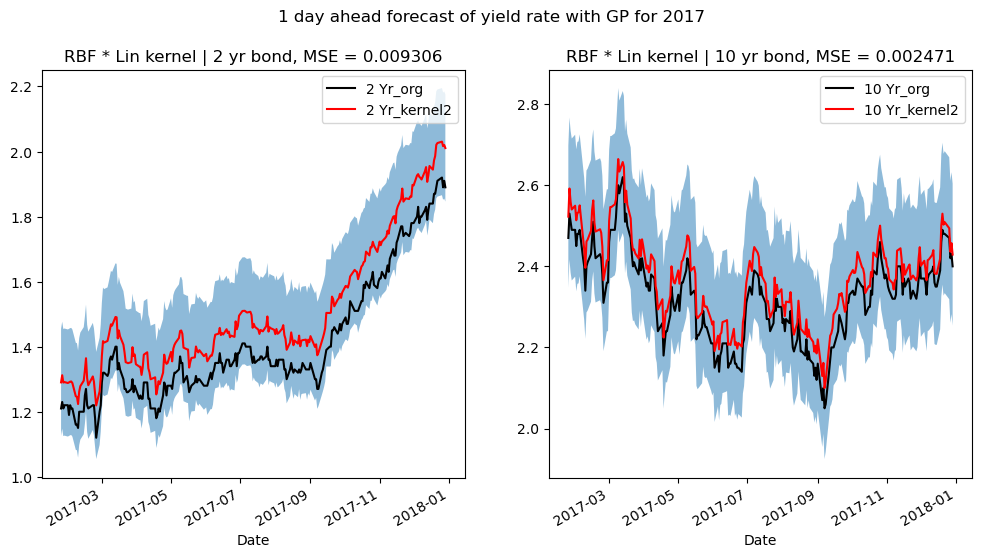

In [77]:
fig,ax = plt.subplots(1,2,figsize=(12,6))
fig.suptitle("1 day ahead forecast of yield rate with GP for 2017")
model_type_i="kernel2"
for i,bond_i in enumerate([2,10]):
    ax_i = ax[i]
    y_i = joinf_2017[f"{bond_i} Yr_{model_type_i}"]
    mse_i = mean_squared_error(joinf_2017[f"{bond_i} Yr_org"],y_i)
    joinf_2017[[f"{bond_i} Yr_org",f"{bond_i} Yr_{model_type_i}"]].plot(ax=ax_i,color=("k","r"))
    ax_i.set_title(f"RBF * Lin kernel | {bond_i} yr bond, MSE = {mse_i:.6f}")
    if model_type_i != "persist":
        ax_i.fill_between(joinf_2017.index, y_i - 0.05*joinf_2017[f"{bond_i} Yr_{model_type_i}_stddev"],\
                          y_i + 0.05*joinf_2017[f"{bond_i} Yr_{model_type_i}_stddev"], alpha=0.5)